In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import shap


import math

In [5]:
df = pd.read_csv("../../Data/df_standardised_end_test_6hr.csv")
df = df.drop(columns = ["Unnamed: 0","X","X1.hr","X2.hr","X3.hr","X5.hr","X6.hr","X7.hr","X8.hr","X9.hr","X10.hr"
                        ,"X11.hr","X12.hr","X13.hr","X14.hr","X15.hr","X16.hr","X17.hr","X18.hr","X19.hr"
                        ,"X20.hr","X21.hr","X22.hr","X23.hr","X24.hr","X25.hr","X26.hr","X27.hr","X28.hr","chunk"])
df

,abnormal,X4.hr,train_test
0,0,-0.437480,train
1,0,-0.024752,train
2,0,-1.372619,train
3,0,-0.601068,train
4,0,0.417116,train
...,...,...,...
31653,0,1.253461,test
31654,0,0.514161,test
31655,0,-0.053325,test
31656,0,-0.091542,test


In [6]:
train = df.loc[df['train_test'] == "train"]
test = df.loc[df['train_test'] == "test"]

In [7]:
y_train = train.pop("abnormal")
X_train = train
X_train = X_train.drop(columns = ["train_test"])
y_test = test.pop("abnormal")
X_test = test
X_test = X_test.drop(columns = ["train_test"])

In [8]:
def get_results(truth, prediction, df, idx):
    

    acc = accuracy_score(truth, prediction)
    f1 = f1_score(truth, prediction)
    precision = precision_score(truth, prediction)
    recall = recall_score(truth, prediction)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df


In [9]:
results = pd.DataFrame(index = ['Decision Tree'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall'])

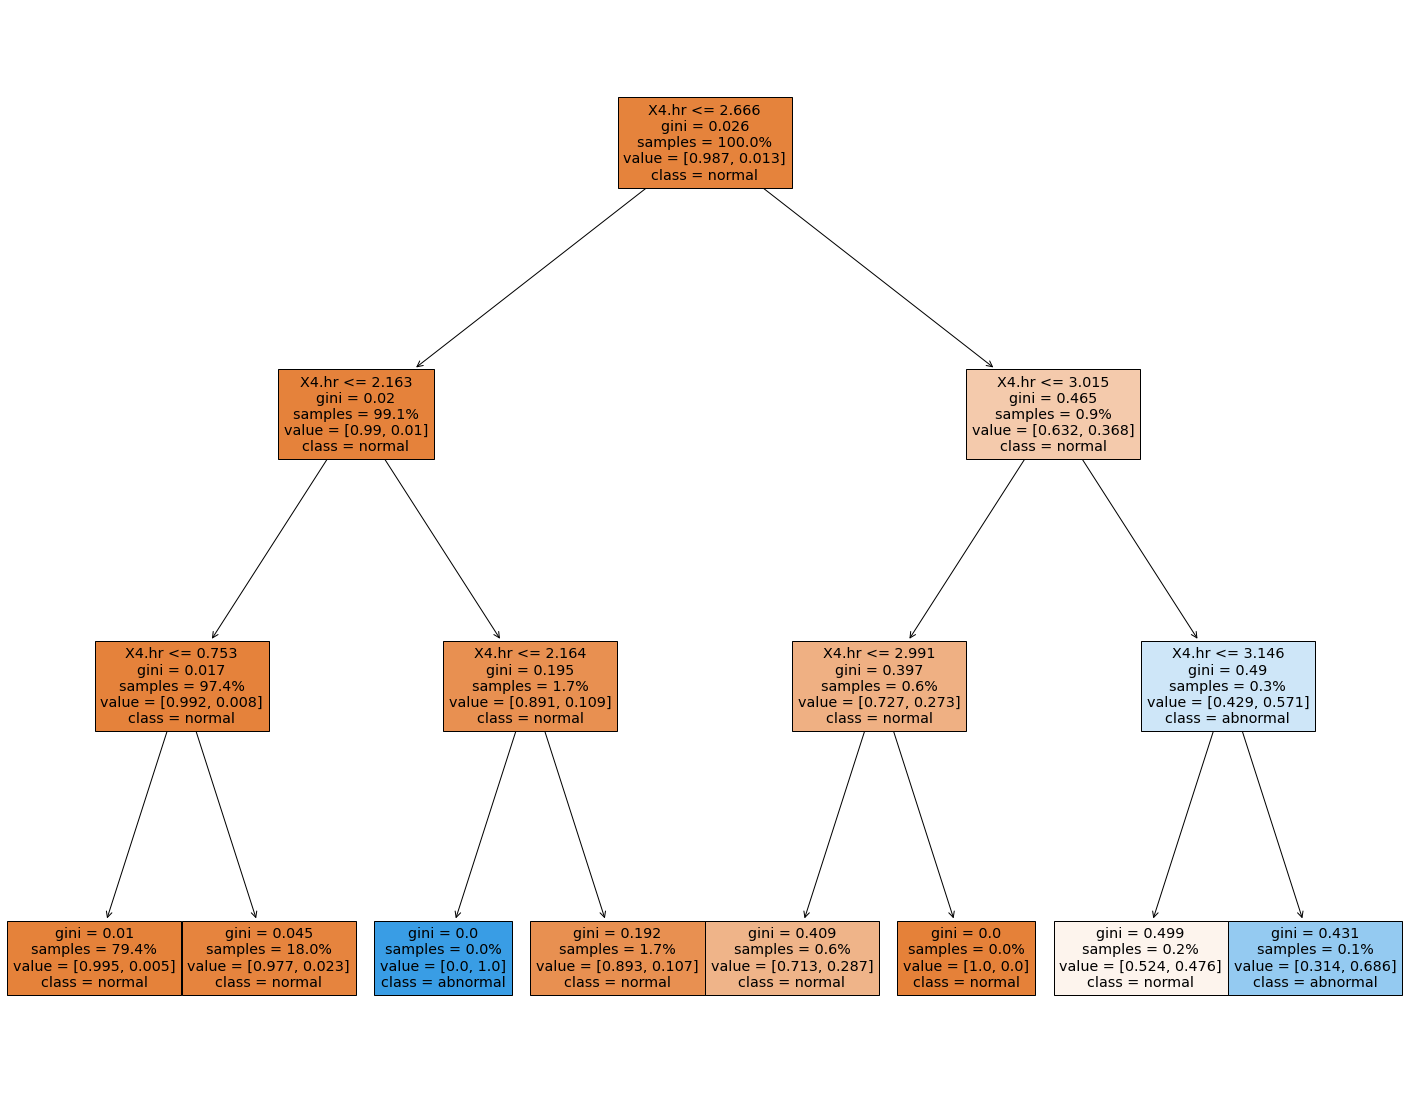

In [10]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 13)
clf.fit(X=X_train,y=y_train)

y_pred = clf.predict(X_test)

results = get_results(y_test, y_pred, results, 'Decision Tree')


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['normal', 'abnormal'],
                   filled=True,  proportion = True)


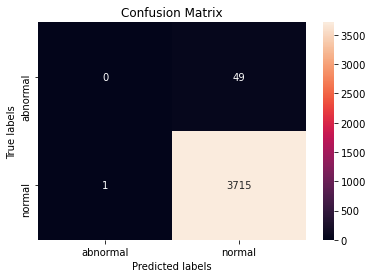

In [11]:
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['abnormal', 'normal']); 
ax.yaxis.set_ticklabels(['abnormal', 'normal'])

plt.show()

In [12]:
results

,accuracy,f1,precision,recall
Decision Tree,0.98672,0,0,0


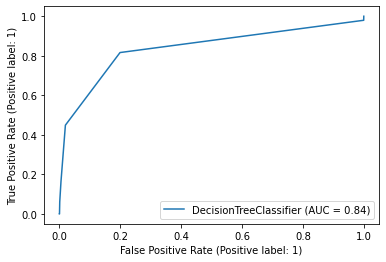

In [13]:
plot_roc_curve(clf,X_test,y_test)
plt.show()

In [14]:
y_score = clf.predict_proba(X_test)

In [15]:
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ["index"])
y_test = y_test.squeeze()

y_pred = pd.Series(y_pred)

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_score[indices, 1])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Bootstrap #1 ROC area: 0.797
Bootstrap #2 ROC area: 0.851
Bootstrap #3 ROC area: 0.888
Bootstrap #4 ROC area: 0.887
Bootstrap #5 ROC area: 0.846
Bootstrap #6 ROC area: 0.781
Bootstrap #7 ROC area: 0.778
Bootstrap #8 ROC area: 0.875
Bootstrap #9 ROC area: 0.822
Bootstrap #10 ROC area: 0.794
Bootstrap #11 ROC area: 0.863
Bootstrap #12 ROC area: 0.813
Bootstrap #13 ROC area: 0.792
Bootstrap #14 ROC area: 0.890
Bootstrap #15 ROC area: 0.871
Bootstrap #16 ROC area: 0.813
Bootstrap #17 ROC area: 0.831
Bootstrap #18 ROC area: 0.734
Bootstrap #19 ROC area: 0.810
Bootstrap #20 ROC area: 0.760
Bootstrap #21 ROC area: 0.814
Bootstrap #22 ROC area: 0.869
Bootstrap #23 ROC area: 0.838
Bootstrap #24 ROC area: 0.899
Bootstrap #25 ROC area: 0.813
Bootstrap #26 ROC area: 0.869
Bootstrap #27 ROC area: 0.829
Bootstrap #28 ROC area: 0.838
Bootstrap #29 ROC area: 0.861
Bootstrap #30 ROC area: 0.747
Bootstrap #31 ROC area: 0.836
Bootstrap #32 ROC area: 0.855
Bootstrap #33 ROC area: 0.830
Bootstrap #34 ROC a

Bootstrap #275 ROC area: 0.854
Bootstrap #276 ROC area: 0.873
Bootstrap #277 ROC area: 0.828
Bootstrap #278 ROC area: 0.865
Bootstrap #279 ROC area: 0.766
Bootstrap #280 ROC area: 0.794
Bootstrap #281 ROC area: 0.810
Bootstrap #282 ROC area: 0.824
Bootstrap #283 ROC area: 0.869
Bootstrap #284 ROC area: 0.755
Bootstrap #285 ROC area: 0.821
Bootstrap #286 ROC area: 0.865
Bootstrap #287 ROC area: 0.832
Bootstrap #288 ROC area: 0.813
Bootstrap #289 ROC area: 0.803
Bootstrap #290 ROC area: 0.777
Bootstrap #291 ROC area: 0.808
Bootstrap #292 ROC area: 0.874
Bootstrap #293 ROC area: 0.786
Bootstrap #294 ROC area: 0.823
Bootstrap #295 ROC area: 0.782
Bootstrap #296 ROC area: 0.859
Bootstrap #297 ROC area: 0.862
Bootstrap #298 ROC area: 0.854
Bootstrap #299 ROC area: 0.761
Bootstrap #300 ROC area: 0.776
Bootstrap #301 ROC area: 0.859
Bootstrap #302 ROC area: 0.796
Bootstrap #303 ROC area: 0.872
Bootstrap #304 ROC area: 0.848
Bootstrap #305 ROC area: 0.881
Bootstrap #306 ROC area: 0.846
Bootstra

Bootstrap #546 ROC area: 0.885
Bootstrap #547 ROC area: 0.811
Bootstrap #548 ROC area: 0.842
Bootstrap #549 ROC area: 0.773
Bootstrap #550 ROC area: 0.830
Bootstrap #551 ROC area: 0.824
Bootstrap #552 ROC area: 0.868
Bootstrap #553 ROC area: 0.821
Bootstrap #554 ROC area: 0.804
Bootstrap #555 ROC area: 0.819
Bootstrap #556 ROC area: 0.858
Bootstrap #557 ROC area: 0.811
Bootstrap #558 ROC area: 0.815
Bootstrap #559 ROC area: 0.853
Bootstrap #560 ROC area: 0.891
Bootstrap #561 ROC area: 0.823
Bootstrap #562 ROC area: 0.882
Bootstrap #563 ROC area: 0.839
Bootstrap #564 ROC area: 0.852
Bootstrap #565 ROC area: 0.819
Bootstrap #566 ROC area: 0.866
Bootstrap #567 ROC area: 0.842
Bootstrap #568 ROC area: 0.842
Bootstrap #569 ROC area: 0.860
Bootstrap #570 ROC area: 0.822
Bootstrap #571 ROC area: 0.845
Bootstrap #572 ROC area: 0.798
Bootstrap #573 ROC area: 0.856
Bootstrap #574 ROC area: 0.906
Bootstrap #575 ROC area: 0.845
Bootstrap #576 ROC area: 0.872
Bootstrap #577 ROC area: 0.853
Bootstra

Bootstrap #817 ROC area: 0.874
Bootstrap #818 ROC area: 0.878
Bootstrap #819 ROC area: 0.847
Bootstrap #820 ROC area: 0.835
Bootstrap #821 ROC area: 0.862
Bootstrap #822 ROC area: 0.788
Bootstrap #823 ROC area: 0.859
Bootstrap #824 ROC area: 0.814
Bootstrap #825 ROC area: 0.824
Bootstrap #826 ROC area: 0.842
Bootstrap #827 ROC area: 0.806
Bootstrap #828 ROC area: 0.837
Bootstrap #829 ROC area: 0.786
Bootstrap #830 ROC area: 0.849
Bootstrap #831 ROC area: 0.819
Bootstrap #832 ROC area: 0.870
Bootstrap #833 ROC area: 0.795
Bootstrap #834 ROC area: 0.759
Bootstrap #835 ROC area: 0.835
Bootstrap #836 ROC area: 0.884
Bootstrap #837 ROC area: 0.836
Bootstrap #838 ROC area: 0.861
Bootstrap #839 ROC area: 0.847
Bootstrap #840 ROC area: 0.823
Bootstrap #841 ROC area: 0.821
Bootstrap #842 ROC area: 0.807
Bootstrap #843 ROC area: 0.771
Bootstrap #844 ROC area: 0.857
Bootstrap #845 ROC area: 0.869
Bootstrap #846 ROC area: 0.847
Bootstrap #847 ROC area: 0.831
Bootstrap #848 ROC area: 0.828
Bootstra